# Comparison of TMM and RCWA methods

This example sets up a structure resembling a triple-junction solar cell and calculates the total reflection and transmission, absorption per layer in the structure, and absorption profiles for different indicent light polarizations and angles. The transfer-matrix method (TMM) and rigorous coupled-wave analysis (RCWA) are both used, to ensure that the results are the same in both cases for a planar structure.

First, we import the relevant libraries, inluding numpy, pyplot, and relevant functions/classes from both Solcore and RayFlare:

In [1]:
import numpy as np
from solcore import si, material
from solcore.structure import Layer
from solcore.constants import q, h, c
from solcore.interpolate import interp1d
from solcore.solar_cell import SolarCell

from rayflare.rigorous_coupled_wave_analysis import rcwa_structure
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.options import default_options

import matplotlib.pyplot as plt

Then we define the relevant materials. This uses the Solcore material class (see the Solcore documentation for further details). We also create an 'options' object which stores the user option by loading the default RayFlare options, and specifying our own wavelengths (in m) and number of RCWA Fourier orders to use (only 2 in this case -- there is no diffraction because we are just testing a planar structure so we don't need to worry about the convergence). Note that it is also possible to supply a dictionary of user options instead of importing the default_options and modifying them. The 'size' variable here are the lattice vectors of the unit cell in the RCWA calculations; here, they can be set to anything, because we are not patterning the layer, but we need to supply this argument to initialize the rcwa_structure later.

In [2]:
InGaP = material('GaInP')(In=0.5)
GaAs = material('GaAs')()
Ge = material('Ge')()
Ag = material('Ag')()
Air = material('Air')()

Al2O3 = material('Al2O3')()

wavelengths = np.linspace(250, 1900, 500) * 1e-9

options = default_options()

options.wavelengths = wavelengths
options.orders = 2

size = ((100, 0), (0, 100))

Now we define the structure. The anti-reflection coating is 80 nm of Al2O3. We then make a Solcore SolarCell object which contains all the layers by passing it a list of Layer objects, with the material and width in each case. This is used to an initialise both the rcwa_structure and tmm_structure classes. The other arguments specify user options (only for the RCWA structure), the incidence medium (air), and the transmission medium (silver). For the tmm_structure, the no_back_reflection argument can also be set: if True, reflections between the back interface and transmission medium are suppressed (so in this case, we set it to False because we want a fully coherent calculation). Note that both the TMM and RCWA calculations can deal with incidence from a medium with real part of the refractive index n =/= 1, but may not behave correctly for an absorbing incidence medium.

In [3]:
ARC = [Layer(si('80nm'), Al2O3)]

solar_cell = SolarCell(ARC + [Layer(material=InGaP, width=si('400nm')),
                               Layer(material=GaAs, width=si('4000nm')),
                               Layer(material=Ge, width=si('3000nm'))])


rcwa_setup = rcwa_structure(solar_cell, size=size, options=options,
                            incidence=Air, transmission=Ag)
tmm_setup = tmm_structure(solar_cell, incidence=Air,
                          transmission=Ag, no_back_reflection=False)

Now that the structures have been set up, we loop through a few different incidence angles for s, p and unpolarized ('u') light incident on the structures. The relevant entries of the options object (pol and theta_in) are set on each loop. The results from boh the TMM (solid lines) and RCWA (dashed lines) calculations are plotted and show that they obtain identical results, as expected for a planar structure. Absorption in the Al2O3 is not plotted because it is non-absorbing (k = 0 everywhere).

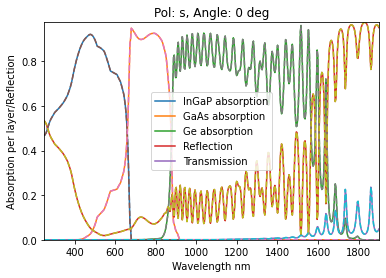

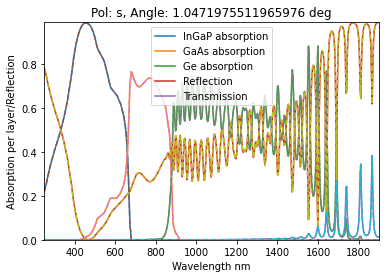

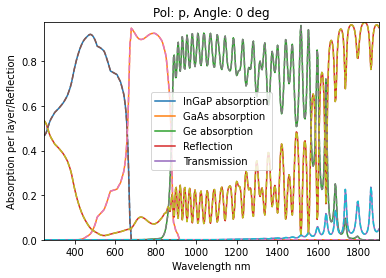

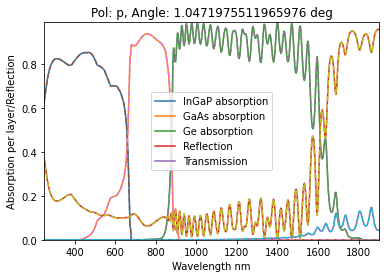

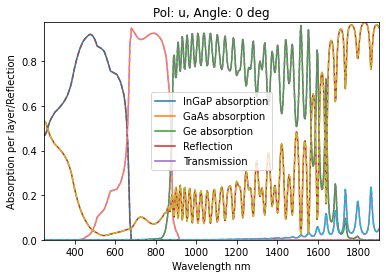

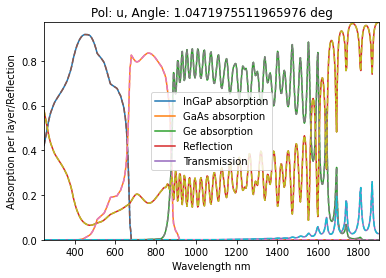

In [4]:
for pol in ['s', 'p', 'u']:
    options.pol = pol
        
    for angle in [0, np.pi/3]:

        options.theta_in = angle

        rcwa_result = rcwa_setup.calculate(options)
        tmm_result = tmm_setup.calculate(options)


        plt.figure()

        plt.plot(wavelengths*1e9, tmm_result['A_per_layer'][:, 1:])
        plt.plot(wavelengths*1e9, tmm_result['R'])
        plt.plot(wavelengths*1e9, tmm_result['T'])
        plt.legend(['InGaP absorption', 'GaAs absorption',
                    'Ge absorption', 'Reflection', 'Transmission'])
        plt.plot(wavelengths*1e9, rcwa_result['A_per_layer'][:, 1:], '--')
        plt.plot(wavelengths*1e9, rcwa_result['R'], '--')
        plt.plot(wavelengths*1e9, rcwa_result['T'], '--')
        plt.title('Pol: ' + options['pol'] + ', Angle: ' + str(options['theta_in']) + ' deg')
        plt.xlabel('Wavelength nm')
        plt.ylabel('Absorption per layer/Reflection')
        plt.autoscale(tight=True)
        plt.show()

We can also calculate the depth-dependent absorption profile using both methods. We will just do this at a few wavelengths, so we change the wavelength option, and set the depth spacing to use for the profile calculation to 10 nm.

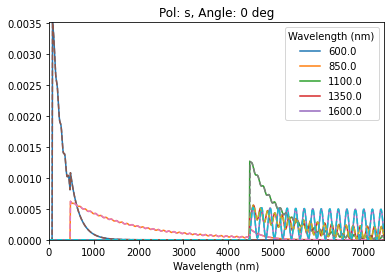

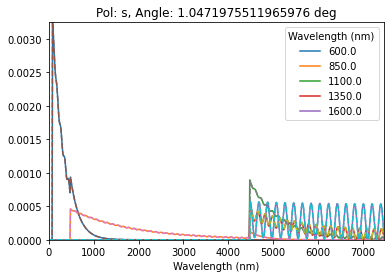

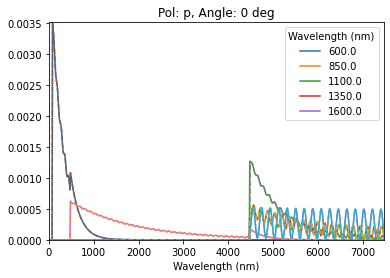

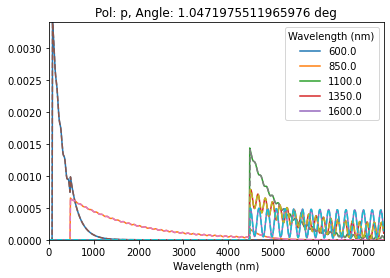

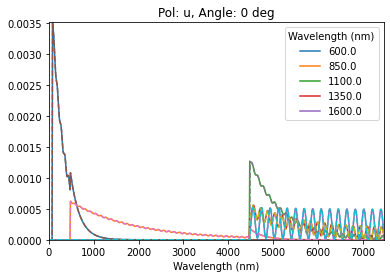

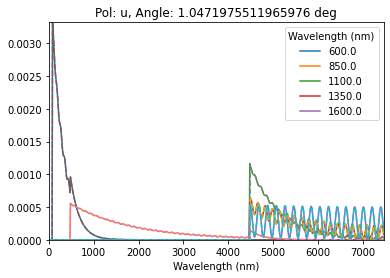

In [5]:
wavelengths_profile = np.arange(600, 1601, 250)*1e-9
options.wavelengths = wavelengths_profile
options.depth_spacing = 10e-9

total_width = np.sum(rcwa_setup.widths[1:-1])
points = np.arange(0, total_width, options.depth_spacing*1e9)


for pol in ['s', 'p', 'u']:
    options['pol'] = pol

    for angle in [0, np.pi/3]:

        options['theta_in'] = angle

        rcwa_result = rcwa_setup.calculate_profile(options)
        tmm_result = tmm_setup.calculate_profile(options)

        plt.figure()

        plt.plot(points, tmm_result['profile'].T)
        plt.plot(points, rcwa_result['profile'].T, '--')
        plt.legend([str(np.round(x*1e9, 0)) for x in wavelengths_profile],
                   title='Wavelength (nm)')
        plt.title('Pol: ' + options['pol'] + ', Angle: ' + str(options['theta_in']) + ' deg')
        plt.autoscale(tight=True)
        plt.xlabel('Wavelength (nm)')
        plt.show()